- Import Libraries

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

- Load and Prepare the  Data

In [18]:
# Load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
valid = pd.read_csv('data/validation.csv')

# Map labels ('ham' -> 0, 'spam' -> 1)
X_train, y_train = train['sms'], train['label'].map({'ham': 0, 'spam': 1})
X_test, y_test = test['sms'], test['label'].map({'ham': 0, 'spam': 1})
X_valid, y_valid = valid['sms'], valid['label'].map({'ham': 0, 'spam': 1})

# Remove missing values
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]

X_valid.dropna(inplace=True)
y_valid = y_valid[X_valid.index]

X_test.dropna(inplace=True)
y_test = y_test[X_test.index]

- Text Vectorization (TF-IDF)

In [19]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)

y_train = y_train.astype('float64')
y_valid = y_valid.astype('float64')
y_test = y_test.astype('float64')

- Set Up MLflow Experiment

In [20]:
# Set MLflow experiment
mlflow.set_experiment("SMS Spam Classification with Hyperparameter Tuning")

<Experiment: artifact_location='file:///d:/CMI/SEM4/AML/Assignment_2/mlruns/600064959698623497', creation_time=1741094266527, experiment_id='600064959698623497', last_update_time=1741094266527, lifecycle_stage='active', name='SMS Spam Classification with Hyperparameter Tuning', tags={}>

- Define Hyperparameter Grids

In [21]:
# Expanded Hyperparameter Grids
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Added more values for finer tuning
    'solver': ['liblinear', 'lbfgs', 'saga']  # Added 'saga' for better optimization
}

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],  # Added 300 for more trees
    'max_depth': [3, 5, 10, 20, None],  # Included 'None' for unlimited depth
    'min_samples_split': [2, 5, 10],  # Added 10 for further exploration
    'min_samples_leaf': [1, 2, 4]  # Added leaf size tuning
}

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'probability': [True]  # Ensure probability is enabled
}




- Model Training and Logging Function

In [22]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc
from mlflow.models.signature import infer_signature
from sklearn.model_selection import GridSearchCV

def train_and_log_model(model, param_grid, model_name):
    with mlflow.start_run(run_name=model_name):
        # Hyperparameter tuning with GridSearchCV
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_tfidf, y_train)

        # Get best model and parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        y_pred = best_model.predict(X_valid_tfidf)
        y_probs = best_model.predict_proba(X_valid_tfidf)[:, 1]  # Probabilities for positive class

        # Evaluate performance
        acc = accuracy_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)

        # Compute Precision-Recall curve and AUCPR
        precision, recall, _ = precision_recall_curve(y_valid, y_probs)
        aucpr = auc(recall, precision)

        # Log best parameters and metrics
        mlflow.log_params(best_params)
        mlflow.log_metric("best_cv_score", grid_search.best_score_)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("aucpr", aucpr)

        # Plot and log AUCPR curve
        plt.figure(figsize=(6, 6))
        plt.plot(recall, precision, marker='.', label=f"AUCPR: {aucpr:.4f}")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f"{model_name} - Precision-Recall Curve")
        plt.legend()
        aucpr_path = f"{model_name}_aupr_curve.png"
        plt.savefig(aucpr_path)
        mlflow.log_artifact(aucpr_path)

        # Infer model signature and input example
        input_example = X_valid_tfidf[:5].toarray()
        signature = infer_signature(X_valid_tfidf.toarray(), y_valid[:5])

        # Log the trained model with signature and input example
        mlflow.sklearn.log_model(best_model, model_name, signature=signature, input_example=input_example)

        print(f"{model_name} training complete. Best params: {best_params}, AUCPR: {aucpr:.4f}")


-  Train and Log Models

Logistic Regression training complete. Best params: {'C': 100, 'solver': 'liblinear'}, AUCPR: 0.9783


c:\Users\Deepanshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Random Forest training complete. Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}, AUCPR: 0.9697


Support Vector Machine training complete. Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear', 'probability': True}, AUCPR: 0.9768
Hyperparameter tuning and training complete! 🚀


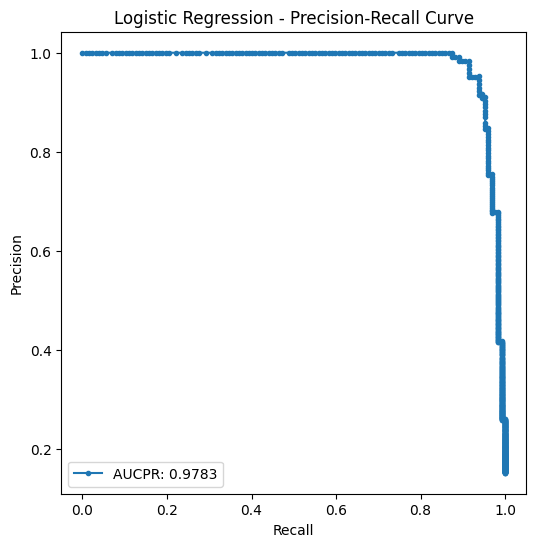

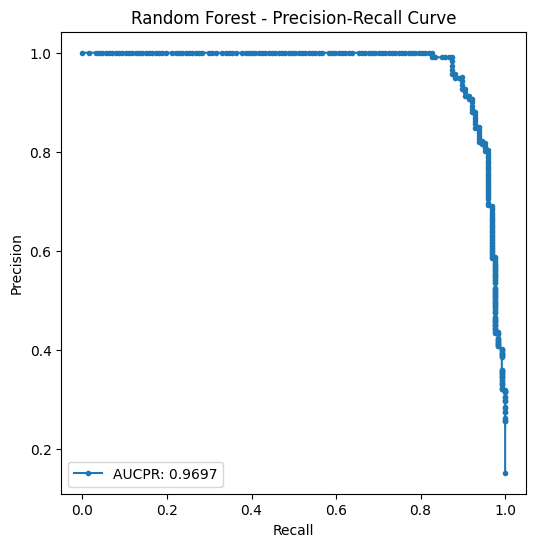

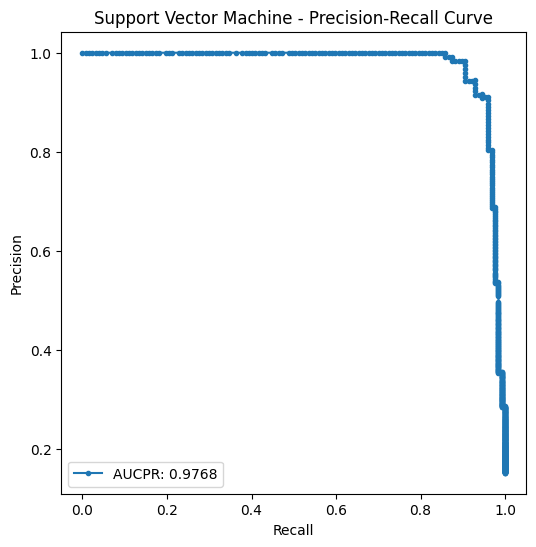

In [23]:
# Train models
train_and_log_model(LogisticRegression(), param_grid_lr, "Logistic Regression")
train_and_log_model(RandomForestClassifier(random_state=42), param_grid_rf, "Random Forest")
train_and_log_model(SVC(probability=True), param_grid_svm, "Support Vector Machine")


print("Hyperparameter tuning and training complete! 🚀")